In [1]:
!git clone https://github.com/Jsrsky/machine_unlearning_experiments
%cd machine_unlearning_experiments/experiments/animal_faces/naive

Cloning into 'machine_unlearning_experiments'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 189 (delta 63), reused 153 (delta 44), pack-reused 0 (from 0)
Receiving objects: 100% (189/189), 26.58 MiB | 26.35 MiB/s, done.
Resolving deltas: 100% (63/63), done.
/kaggle/working/machine_unlearning_experiments/experiments/animal_faces/naive


## Dependecies

In [2]:
import sys
from pathlib import Path
from torchvision import datasets

## Utils

In [3]:
project_root = Path.cwd().resolve().parents[2]
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    
data_root = project_root / 'data'
data_root.mkdir(parents=True, exist_ok=True)

from notebook_setup import setup_notebook
setup_notebook()

Notebook setup completed. Project root added to sys.path: /kaggle/working/machine_unlearning_experiments


# DELETE IF GOING FOR LOCAL SETUP, ADD AHFQ DATASET TO "./data" FOLDER

In [4]:
data_root = Path('/kaggle/input/animal-faces')

In [5]:
# Device configuration
from utils.utils import DEVICE

print(f"Device used: {DEVICE}")

# Set random seed for reproducibility
from utils.utils import set_seed
set_seed()

# Prepare Dataloaders
from methods.naive.naive_utils import init_dataloaders

# Train loop
from utils.train_test_metrics import train_model

# Plot losses
from utils.train_test_metrics import plot_training_history

# Test function
from utils.train_test_metrics import test_model

# Merics 
from utils.train_test_metrics import show_metrics

# Init model
from models.effnetb0 import init_model_effnetb0

Device used: cuda


## Parameters (arbitrary chosen)

In [6]:
BATCH_SIZE = 32
LEARNING_RATE = 0.01
EPOCHS = 5

# Simple base training

## Init model

In [7]:
model, model_name, criterion, optimizer, transform = init_model_effnetb0(learning_rate=LEARNING_RATE, fc_output=3)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


Init model...


100%|██████████| 20.5M/20.5M [00:00<00:00, 197MB/s]


Done initializing model.
Model ID: 132247119797968, Optimizer ID: 132247119800272, Criterion ID: 132247119800224


## Init dataloaders

In [8]:
train_dataset = datasets.ImageFolder(root=data_root/'afhq/train', transform=transform)
test_dataset = datasets.ImageFolder(root=data_root/'afhq/val', transform=transform)
data_split_path = 'afhq_data_splits.json'

train_loader, val_loader, test_loader, classes = init_dataloaders(
    datasets=(train_dataset, test_dataset),
    val_ratio=0.2,
    batch_size=BATCH_SIZE,
    info_file_path = data_split_path,
    )

Prepare DataLoaders...
Done preparing DataLoaders.


## Call train

In [9]:
train_model(model, model_name, train_loader, val_loader, criterion, optimizer, num_epochs=EPOCHS)

Evaluating on validation set...: 100%|██████████| 92/92 [00:22<00:00,  4.15it/s]


Epoch [1/5], Train Loss: 0.2911, Train Accuracy: 0.8996, Val Loss: 0.1955, Val Accuracy: 0.9289
Epoch 1: New best validation accuracy: 0.9289. Model saved to EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 92/92 [00:22<00:00,  4.05it/s]


Epoch [2/5], Train Loss: 0.1014, Train Accuracy: 0.9653, Val Loss: 0.0733, Val Accuracy: 0.9768
Epoch 2: New best validation accuracy: 0.9768. Model saved to EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 92/92 [00:21<00:00,  4.27it/s]


Epoch [3/5], Train Loss: 0.0625, Train Accuracy: 0.9780, Val Loss: 0.0661, Val Accuracy: 0.9792
Epoch 3: New best validation accuracy: 0.9792. Model saved to EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 92/92 [00:21<00:00,  4.19it/s]


Epoch [4/5], Train Loss: 0.0669, Train Accuracy: 0.9777, Val Loss: 0.0750, Val Accuracy: 0.9720


Evaluating on validation set...: 100%|██████████| 92/92 [00:21<00:00,  4.23it/s]

Epoch [5/5], Train Loss: 0.0558, Train Accuracy: 0.9829, Val Loss: 0.0494, Val Accuracy: 0.9846
Epoch 5: New best validation accuracy: 0.9846. Model saved to EffNetB0_AFHQ_model.pth.
Training complete for EffNetB0_AFHQ. Training stats saved to 'EffNetB0_AFHQ_history.json'.


## Plot history losses

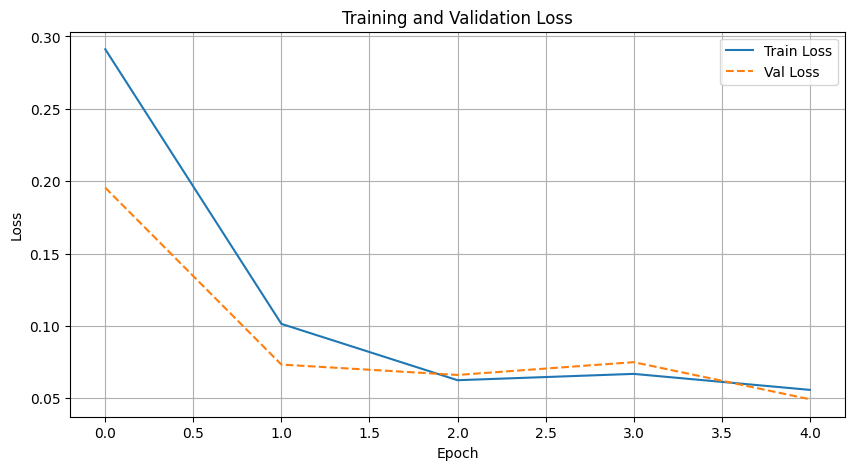

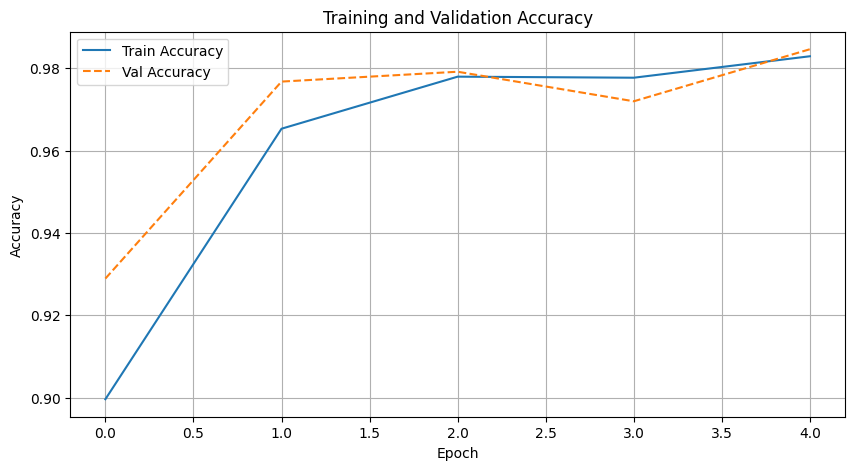

In [10]:
history_path = f'{model_name}_history.json'
plot_training_history(history_path)

## Call test

In [11]:
model_path = f"{model_name}_model.pth"
test_model(model, model_name, model_path, test_loader)

Loading and testing model: EffNetB0_AFHQ


Evaluating model: EffNetB0_AFHQ_model.pth: 100%|██████████| 47/47 [00:11<00:00,  4.25it/s]

Predictions and labels saved to EffNetB0_AFHQ_predictions.json


## Show metrics

Metrics for EffNetB0_AFHQ:
  - Test Accuracy: 0.9873
  - Precision: 0.9874
  - Recall: 0.9873
  - F1 Score: 0.9873


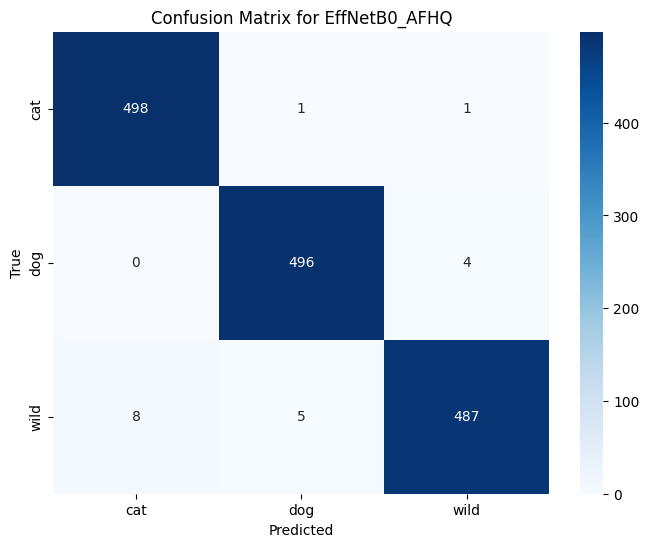

In [12]:
predictions_path = f'{model_name}_predictions.json'
#classes = ['cat', 'dog', 'wildlife']
show_metrics(predictions_path, classes, model_name)

## Utils naive

In [13]:
# Select samples to unlearn (10% random)
from utils.utils import select_samples_to_unlearn

# Update data splits
from methods.naive.naive_utils import update_splits_after_unlearning

# Recreate Dataloaders from json files
from methods.naive.naive_utils import recreate_dataloaders

# Naive unlearning

### Init new model

In [14]:
data_splits_file = "afhq_data_splits.json"
unlearn_samples_file = "afhq_samples_to_unlearn.json"
updated_data_splits_path = "updated_afhq_data_splits.json"

In [15]:
model, model_name, criterion, optimizer, transform = init_model_effnetb0(learning_rate=LEARNING_RATE, fc_output=3)
model_name = "naive_unlearning_" + model_name

Init model...
Done initializing model.
Model ID: 132247097768208, Optimizer ID: 132247097764992, Criterion ID: 132247097769216


### Init data

In [16]:
train_dataset = datasets.ImageFolder(root=data_root/'afhq/train', transform=transform)
test_dataset = datasets.ImageFolder(root=data_root/'afhq/val', transform=transform)

## Select samples to unlearn

In [17]:
#ONLY ONCE
select_samples_to_unlearn(data_splits_file, unlearn_samples_file, unlearn_ratio=0.1)

Unlearn indices saved to afhq_samples_to_unlearn.json


## Update data splits -> delete samples

In [18]:
update_splits_after_unlearning(data_splits_file, unlearn_samples_file, updated_data_splits_path)

Updated splits saved to updated_afhq_data_splits.json


## Recreate DataLoaders from json files

In [20]:
train_loader, val_loader, test_loader, classes = recreate_dataloaders(
    data_splits_file=updated_data_splits_path,
    datasets=(train_dataset, test_dataset), 
    batch_size=BATCH_SIZE)

Recreating DataLoaders...
Done recreating DataLoaders.


## Re-train

In [21]:
train_model(model, model_name, train_loader, val_loader, criterion, optimizer, num_epochs=EPOCHS)

Evaluating on validation set...: 100%|██████████| 83/83 [00:20<00:00,  4.12it/s]


Epoch [1/5], Train Loss: 0.3125, Train Accuracy: 0.8889, Val Loss: 0.1672, Val Accuracy: 0.9425
Epoch 1: New best validation accuracy: 0.9425. Model saved to naive_unlearning_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 83/83 [00:20<00:00,  4.11it/s]


Epoch [2/5], Train Loss: 0.1004, Train Accuracy: 0.9652, Val Loss: 0.0601, Val Accuracy: 0.9800
Epoch 2: New best validation accuracy: 0.9800. Model saved to naive_unlearning_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 83/83 [00:19<00:00,  4.27it/s]


Epoch [3/5], Train Loss: 0.0773, Train Accuracy: 0.9734, Val Loss: 0.0591, Val Accuracy: 0.9826
Epoch 3: New best validation accuracy: 0.9826. Model saved to naive_unlearning_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 83/83 [00:20<00:00,  4.13it/s]


Epoch [4/5], Train Loss: 0.0669, Train Accuracy: 0.9769, Val Loss: 0.1530, Val Accuracy: 0.9580


Evaluating on validation set...: 100%|██████████| 83/83 [00:20<00:00,  4.14it/s]

Epoch [5/5], Train Loss: 0.0825, Train Accuracy: 0.9728, Val Loss: 0.1472, Val Accuracy: 0.9614
Training complete for naive_unlearning_EffNetB0_AFHQ. Training stats saved to 'naive_unlearning_EffNetB0_AFHQ_history.json'.


## Plot history losses

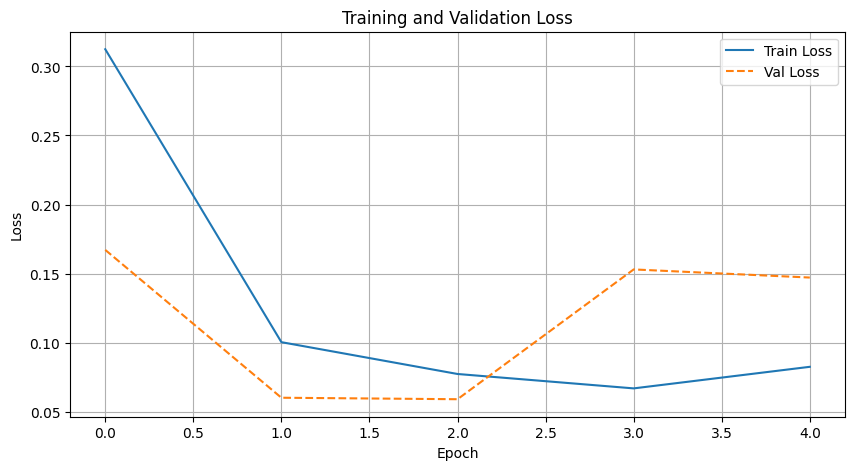

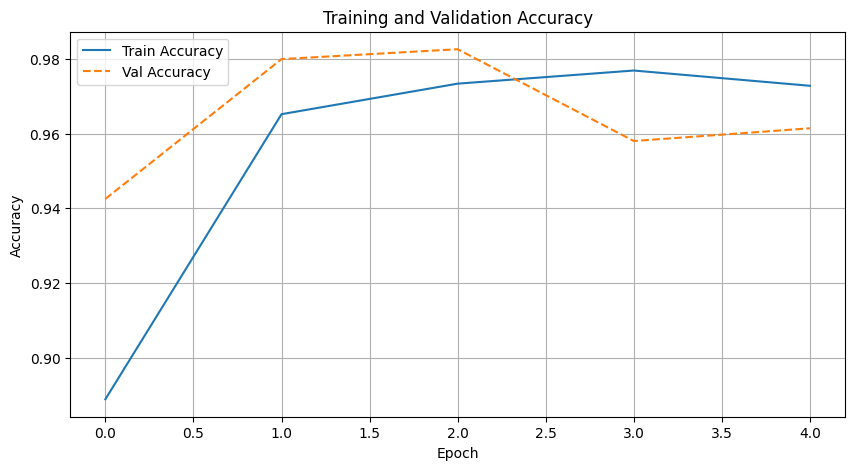

In [22]:
history_path = f'{model_name}_history.json'
plot_training_history(history_path)

## Re-test

In [23]:
model_path = f"{model_name}_model.pth"
test_model(model, model_name, model_path, test_loader)

Loading and testing model: naive_unlearning_EffNetB0_AFHQ


Evaluating model: naive_unlearning_EffNetB0_AFHQ_model.pth: 100%|██████████| 47/47 [00:10<00:00,  4.31it/s]

Predictions and labels saved to naive_unlearning_EffNetB0_AFHQ_predictions.json


## Show metrics

Metrics for naive_unlearning_EffNetB0_AFHQ:
  - Test Accuracy: 0.9860
  - Precision: 0.9863
  - Recall: 0.9860
  - F1 Score: 0.9860


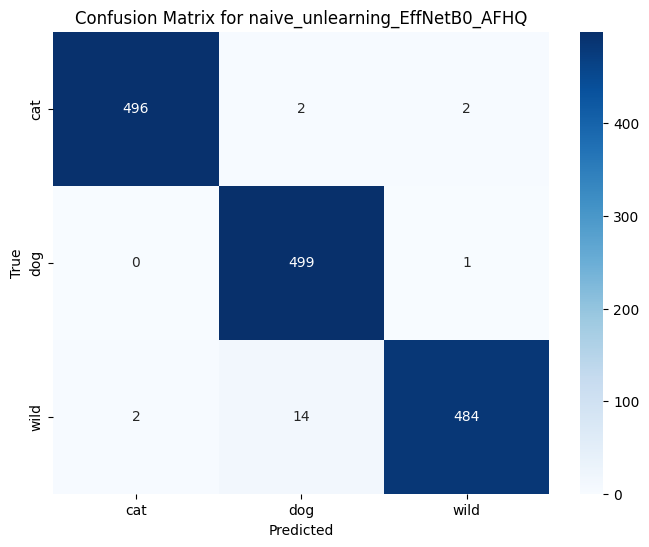

In [24]:
predictions_path = f'{model_name}_predictions.json'
#classes = ['cat', 'dog', 'wildlife']
show_metrics(predictions_path, classes, model_name)